# CRISPR Guide RNA Analysis
by Callum Hutchinson
<img src="images/crispr_header_img.png" alt="Drawing" style="width: 400px;"/>

In [592]:
#load required packages
library(tidyverse)
library(readr)
library(repr)
library(gridExtra)
library(stringr)
options("scipen"=100, "digits"=4)
options(repr.plot.width=10, repr.plot.height=4)

## Introduction

The CRISPR/Cas9 system is a genome editing method developed through adapting the immune system of unicellular organisms called prokaryotes. This form of bacteria integrates sections of invading virus DNA into its own DNA forming a CRISPR array, allowing the bacteria to remember previous infections. The bacteria can now defend against future invasion by creating an RNA segment specific to the particular virus from its CRISPR array, and then use a Cas9 protein to cut the virus DNA at the match site, disabling it.

In the following sections we will analyse the results of a functional screen, in which a multitude of guide sequences targeting many different genes are introduced into a population of cells in parallel. In doing so we aim to identify which guide sequences cut the DNA at functionally essential sites, causing the host cell to die and the sequence decrease in abundance. By conducting a comparitive analysis between the most and least effective guides we hope to uncover the characteristics of sequences which result in depletion of a cell. Such knowledge is clearly pertinent to the treatment of cancers and prevention of tumor growth.

The following analysis was conducted using tools in R, MATLAB and C++.

## 1. The Data 

The data used in the following analysis comes from an experiement in which several hundred genes in a cancer cell line were targeted at different locations in the DNA sequence. The gene targeted, guide sequence and counts of the guide at different times and under different conditions were taken.

In [593]:
#load the data
crispr_data = suppressMessages(read_delim("data/example_guide_data.tsv", "\t", escape_double = FALSE, trim_ws = TRUE))
head(crispr_data)

gene_name,spacer_id,spacer_seq,norm_count_plasmid,norm_count_D7_Rep1,norm_count_D7_Rep2,norm_count_D14_Rep1,norm_count_D14_Rep2,norm_count_PLX7_Rep1,norm_count_PLX7_Rep2,norm_count_PLX14_Rep1,norm_count_PLX14_Rep2
A1BG,s_1,ACCTGTAGTTGCCGGCGTGC,10.367,8.143,10.177,7.986,6.462,12.261,9.095,4.286,2.817
A1BG,s_2,GTCGCTGAGCTCCGATTCGA,8.806,9.941,8.059,8.605,6.462,7.491,10.516,4.168,5.240
A1CF,s_3,AAGTTGCTTGATTGCATTCT,19.493,26.025,25.203,33.278,21.515,19.254,27.914,9.801,9.328
A1CF,s_4,ACTTCCCCGAGACCTTTTTG,20.454,23.148,23.388,28.856,20.649,20.688,21.168,7.220,8.823
A1CF,s_5,AGTGCCGCTCAATCCATCCC,40.869,54.802,54.953,56.270,53.353,51.996,47.869,12.207,13.769
A1CF,s_6,CGCGCACTGGTCCAGCGCAC,23.216,22.223,25.405,22.047,21.781,27.108,21.807,21.125,22.450


<b>Column 1:</b> Gene Name <br />
<b>Column 2:</b> Guide ID <br />
<b>Column 3:</b> Guide Sequence <br />
<b>Column 4:</b> Count before introduction to cells <br />
<b>Column 5/6:</b> Count 7 days after introduction to cells (2 replicates)  <br />
<b>Column 7/8:</b> Count 14 days after introduction to cells (2 replicates) <br />
<b>Column 9/10:</b> Count 7 days after introduction to cells with PLX (Vemurafenib) (2 replicates) <br />
<b>Column 11/12:</b> Count 14 days after introduction to cells with PLX (Vemurafenib) (2 replicates) <br />


We can see the dataset has 64076 rows, 12 columns, 17419 unique genes and 64076 unique guide sequences.

In [594]:
print("Number of rows: ")
nrow(crispr_data)

print("Number of columns: ")
ncol(crispr_data)

print("Number of unique genes: ")
crispr_data %>% group_by(gene_name) %>% count() %>% nrow()

print("Number of unique sequences: ")
crispr_data %>% group_by(spacer_seq) %>% count() %>% nrow()

[1] "Number of rows: "


[1] 64076

[1] "Number of columns: "


[1] 12

[1] "Number of unique genes: "


[1] 17419

[1] "Number of unique sequences: "


[1] 64076


We will start by combining the replicates for each count and condition into an average of the two and discarding the unneeded columns:

In [595]:
#create new columns to average the two repitions into one result for both drug and no drug conditions
crispr_data = mutate(crispr_data,avg_D7=(norm_count_D7_Rep1+norm_count_D7_Rep2)/2)
crispr_data = mutate(crispr_data,avg_D14=(norm_count_D14_Rep1+norm_count_D14_Rep2)/2)
crispr_data = mutate(crispr_data,avg_D7_PLX=(norm_count_PLX7_Rep1+norm_count_PLX7_Rep2)/2)
crispr_data = mutate(crispr_data,avg_D14_PLX=(norm_count_PLX14_Rep1+norm_count_PLX14_Rep2)/2)
#clean up columns
crispr_data = dplyr::select(crispr_data, gene_name,spacer_id,spacer_seq,plasmid=norm_count_plasmid,avg_D7,avg_D14,avg_D7_PLX,avg_D14_PLX)

<br />
We can now calulate the activity of the guides over 7 and 14 days for the two conditions (drug/no drug), where a higher activity indicates a larger depletion in count of the guide. The guides with the largest activities are the focus of this investigation as this indicates the host cell was killed:
<br />

In [596]:
#calculate the activity of the guide (-log2(count_t2/count_t1)) for each condition
crispr_data = mutate(crispr_data, D7_activity= -log2(avg_D7/plasmid), D7_activity_PLX = -log2(avg_D7_PLX/plasmid), D14_activity = -log2(avg_D14/plasmid), D14_activity_PLX = -log2(avg_D14_PLX/plasmid))
head(crispr_data)

gene_name,spacer_id,spacer_seq,plasmid,avg_D7,avg_D14,avg_D7_PLX,avg_D14_PLX,D7_activity,D7_activity_PLX,D14_activity,D14_activity_PLX
A1BG,s_1,ACCTGTAGTTGCCGGCGTGC,10.367,9.16,7.224,10.678,3.551,0.17857,-0.04269,0.52111,1.54552
A1BG,s_2,GTCGCTGAGCTCCGATTCGA,8.806,9.00,7.533,9.003,4.704,-0.03154,-0.03205,0.22511,0.90455
A1CF,s_3,AAGTTGCTTGATTGCATTCT,19.493,25.61,27.396,23.584,9.564,-0.39396,-0.27482,-0.49100,1.02724
A1CF,s_4,ACTTCCCCGAGACCTTTTTG,20.454,23.27,24.753,20.928,8.021,-0.18594,-0.03305,-0.27519,1.35050
A1CF,s_5,AGTGCCGCTCAATCCATCCC,40.869,54.88,54.812,49.932,12.988,-0.42521,-0.28898,-0.42348,1.65383
A1CF,s_6,CGCGCACTGGTCCAGCGCAC,23.216,23.81,21.914,24.457,21.788,-0.03667,-0.07514,0.08326,0.09161


In [597]:
#investigate the range of activities in the dataset and percentage of sequences which
#had negative activity over 14 days

print("Activity over 14 days")
summary(crispr_data$D14_activity)

print("Percentage of observations with negative activity over 14 days:")
(crispr_data %>% filter(D14_activity<0) %>% nrow()/nrow(crispr_data))

print("Activity over 14 days (PLX)")
summary(crispr_data$D14_activity_PLX)

print("Percentage of observations with negative activity over 14 days (PLX):")
(crispr_data %>% filter(D14_activity_PLX<0) %>% nrow()/nrow(crispr_data))

[1] "Activity over 14 days"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -3.919  -0.324   0.043   0.122   0.490   4.304 

[1] "Percentage of observations with negative activity over 14 days:"


[1] 0.4694

[1] "Activity over 14 days (PLX)"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-10.969   0.691   1.321   1.220   1.893   4.944 

[1] "Percentage of observations with negative activity over 14 days (PLX):"


[1] 0.09645

<br />
We notice an interesting observation through looking at the summary of the activites over 14 days both with and without the drug. With PLX we see a significantly larger mean and median activity, suggesting the drug may act synergistically with the CRISPR, although we do not have measurements for PLX only to compare with. Further, without PLX ~47% of the sequences had negative activity over 14 days, indicating that the host cell was not successfully killed, in contrast to only ~10% with PLX.

On the other hand, the range of activity is much larger for the PLX condition with the lowest activity at -10.96 being significantly lower than lowest activity without PLX at -3.92. This is possibly a result of the fact Vemurafenib (PLX) may in fact promote tumor growth when used with cancers which are not a melanoma with the V600E BRAF mutation, of which only 60% have [1].

## 2. Literature Research

Before we begin adding more information to the data it is neccesary to consult the literature and determine if previous research has unearthed features correlated with guide activity and effectiveness.

Taking heed of Wong et al. [2], it is hypothesised that structural characteristics of the guide sequence may be important in determining the ability to bind and cut the target. In order to investigate this we will use the Oligoprop package from the Bioinformatics toolbox in MATLAB to identify the number of hairpins possible in the sequence.

We see that ~80% of the guides in the dataset do not contain any hairpins, ~18% contain one and ~2% contain two.


In [598]:
#read the number of hairpins for each sequence in from MATLAB and add to data set
num_hairpins = suppressMessages(read_csv("data/num_hairpins.txt",col_names = FALSE))
num_hairpins = as.integer(unlist(strsplit(as.character(num_hairpins[1,1]),split=NULL)))
crispr_data$hairpins = num_hairpins
options(scipen=999)
#display frequency of number of hairpins
crispr_data %>% group_by(hairpins) %>% count() %>% mutate(percentage = n/nrow(crispr_data))


hairpins,n,percentage
0,51133,0.79800549
1,11499,0.17945877
2,1340,0.02091267
3,100,0.00156065
4,3,0.00004682
5,1,0.00001561


In [599]:
print("Correlation between number of hairpins and activity over 7 days:")
cor(crispr_data$D7_activity,crispr_data$hairpins)
print("Correlation between number of hairpins and activity over 14 days:")
cor(crispr_data$D14_activity,crispr_data$hairpins)
print("Correlation between number of hairpins and activity over 7 days (PLX):")
cor(crispr_data$D7_activity_PLX,crispr_data$hairpins)
print("Correlation between number of hairpins and activity over 14 days (PLX):")
cor(crispr_data$D14_activity_PLX,crispr_data$hairpins)

[1] "Correlation between number of hairpins and activity over 7 days:"


[1] -0.04797

[1] "Correlation between number of hairpins and activity over 14 days:"


[1] -0.04223

[1] "Correlation between number of hairpins and activity over 7 days (PLX):"


[1] -0.04533

[1] "Correlation between number of hairpins and activity over 14 days (PLX):"


[1] -0.03115

<br />
Above we can see small negative correlations between the activity of the guide and the number of hairpins, indicating that guide sequences which have a propensity to form secondary structures are less effective.

As per the research of Jensen et al. [3], the Gibbs free energy change for folding of the guide sequence effects the ability of the Cas9 protein complex to cleave DNA, with more stable secondary structures being particularly detrimental. As such, we will extract this information from Oligoprop and add it to our dataset:
<br />

In [600]:
#import deltaG from oligoprop
deltaG = suppressMessages(read_csv("data/deltaG.txt",col_names = FALSE))
deltaG = as.double(unlist(strsplit(as.character(deltaG[1,1]),split=" ")))
crispr_data$deltaG = deltaG

print("Correlation between deltaG and activity over 14 days")
cor(crispr_data$D14_activity,crispr_data$deltaG)
print("Correlation between deltaG and activity over 14 days (PLX)")
cor(crispr_data$D14_activity_PLX,crispr_data$deltaG)


[1] "Correlation between deltaG and activity over 14 days"


[1] 0.161

[1] "Correlation between deltaG and activity over 14 days (PLX)"


[1] 0.0935

<br />
Indeed we see a weak positive correlation between the activity over 14 days and the Gibb's free energy, however this relationship is weaker for the PLX condition. 

If we run a linear regression with activity as the response variable and Gibb's free energy the explanitory variable we see that the activity of a guide increases by approximately 0.02 for each kcal/mol that Gibb's free energy increases. We therefore observe the findings of Jensen et al. in the dataset, whereby large negative Gibb's free energy values negatively impact guide activity as stable secondary structures are able to form - to the detriment of the Cas9 protein's function.
<br />

In [601]:
print("D14_activity")
summary(lm(crispr_data$D14_activity~crispr_data$deltaG))$coefficients

print("D14_activity_PLX")
summary(lm(crispr_data$D14_activity_PLX~crispr_data$deltaG))$coefficients

[1] "D14_activity"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.95396,0.0203256,46.93,0
crispr_data$deltaG,0.02492,0.0006036,41.29,0


[1] "D14_activity_PLX"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.97596,0.0320772,61.60,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
crispr_data$deltaG,0.02264,0.0009525,23.77,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002322


<br />

Further research conducted by Doench et al. [4] has identified position specific characteristics of the most effective guide sequences. In their experiment it was found that at the position directly adjacent to the PAM, a sequence which acts as a binding signal for Cas9, guanine is strongly prefered and cytosine is strongly not. The study also found a preference for cytosine at position 16.

<br />
<img src="images/doench_study.png" alt="Drawing" style="width: 600px;"/>



In [602]:
#detect if the last base in the seqence is a G
G_end = lapply(crispr_data$spacer_seq, function(x) strsplit(x,split=NULL)[[1]][20]=="G")
crispr_data$G_end = as.numeric(G_end)
    
#detect if position 16 is a C
C_16 = lapply(crispr_data$spacer_seq, function(x) strsplit(x,split=NULL)[[1]][16]=="C")
crispr_data$C_16 = as.numeric(C_16)
    
print("Linear regression for activity over 14 days and a G at position 20")
print("without PLX:")
summary(lm(crispr_data$D14_activity~crispr_data$G_end))$coefficients
print("with PLX:")
summary(lm(crispr_data$D14_activity_PLX~crispr_data$G_end))$coefficients
    
print("Linear regression for activity over 14 days and a C at position 16")
print("without PLX:")
summary(lm(crispr_data$D14_activity~crispr_data$C_16))$coefficients
print("with PLX:")
summary(lm(crispr_data$D14_activity_PLX~crispr_data$C_16))$coefficients

[1] "Linear regression for activity over 14 days and a G at position 20"
[1] "without PLX:"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.10895,0.003048,35.744,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000004478
crispr_data$G_end,0.06115,0.006610,9.251,0.0000000000000000000229826313768718118453382684518008993435793742128521081153832983368090481235412880778312683105468750000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


[1] "with PLX:"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.2162,0.004771,254.894,0.00000
crispr_data$G_end,0.0182,0.010348,1.759,0.07856


[1] "Linear regression for activity over 14 days and a C at position 16"
[1] "without PLX:"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.10938,0.003255,33.602,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002185
crispr_data$C_16,0.04065,0.005854,6.944,0.00000000000384056911550732573893866357602764401591582954509362934913951903581619262695312500000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


[1] "with PLX:"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),1.21115,0.005094,237.763,0.000000
crispr_data$C_16,0.02887,0.009160,3.152,0.001625


<br/>

We see a small positive effect on the activity over 14 days with both of these features, with some uncertainty for the guanine at position 20 in the PLX condition.

In accordance with the findings of Doench et al. [4] we see that these features are represented in greater numbers for the more effective guides in a modest but statistically significant way.

<br/>

[1] "Proportion test for G at position 20"



	2-sample test for equality of proportions without continuity
	correction

data:  proportions out of trials
X-squared = 52, df = 1, p-value = 0.0000000000003
alternative hypothesis: greater
95 percent confidence interval:
 0.01805 1.00000
sample estimates:
prop 1 prop 2 
0.2236 0.2002 


[1] "Proportion test for C at position 16"



	2-sample test for equality of proportions without continuity
	correction

data:  proportions out of trials
X-squared = 34, df = 1, p-value = 0.000000003
alternative hypothesis: greater
95 percent confidence interval:
 0.01531 1.00000
sample estimates:
prop 1 prop 2 
0.3193 0.2979 


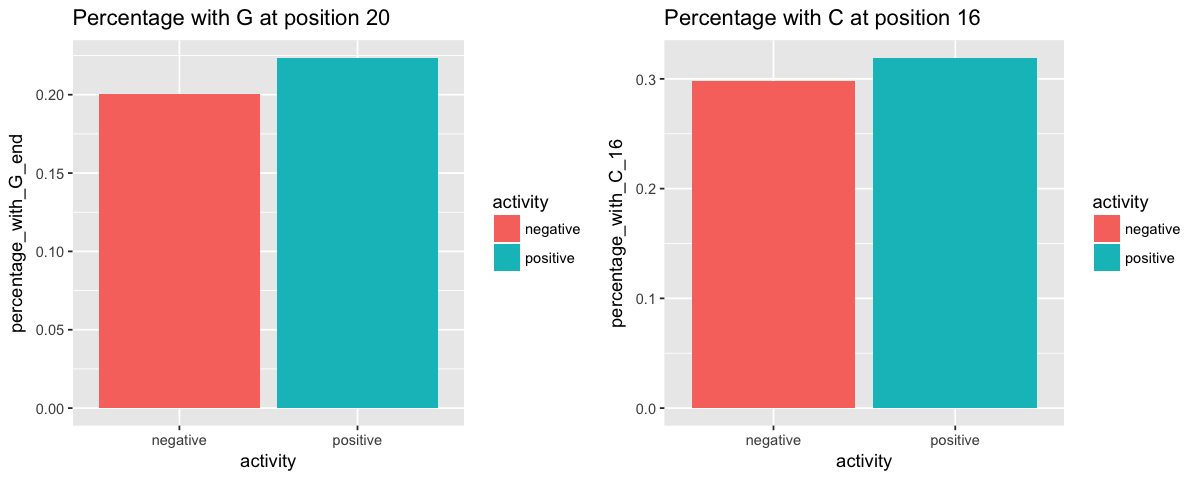

In [603]:
G_pos = crispr_data %>% filter(D14_activity>0) %>% summarize(percentage_with_G_end = mean(G_end)) %>% mutate(activity ="positive")
G_neg = crispr_data %>% filter(D14_activity<0) %>% summarize(percentage_with_G_end = mean(G_end)) %>% mutate(activity ="negative")
C_pos = crispr_data %>% filter(D14_activity>0) %>% summarize(percentage_with_C_16 = mean(C_16)) %>% mutate(activity ="positive")
C_neg = crispr_data %>% filter(D14_activity<0) %>% summarize(percentage_with_C_16 = mean(C_16)) %>% mutate(activity ="negative")
no_plx_G_table = rbind(G_pos,G_neg)
no_plx_C_table = rbind(C_pos,C_neg)

#plot the percentages for each feature
p1 = ggplot(no_plx_G_table) + geom_col(mapping=aes(x=activity,y=percentage_with_G_end,fill=activity)) + ggtitle("Percentage with G at position 20")
p2 = ggplot(no_plx_C_table) + geom_col(mapping=aes(x=activity,y=percentage_with_C_16,fill=activity)) + ggtitle("Percentage with C at position 16")
grid.arrange(p1, p2, ncol = 2)

#do a proportion test for each to determine if the result is statistically significant
print("Proportion test for G at position 20")
proportions = c(as.numeric(no_plx_G_table[1,1]),as.numeric(no_plx_G_table[2,1]))
trials = c(nrow(crispr_data %>% filter(D14_activity>0)),nrow(crispr_data %>% filter(D14_activity<0)))
proportions = proportions*trials
prop.test(proportions,trials,alternative="greater",correct="FALSE")
print("Proportion test for C at position 16")
proportions = c(as.numeric(no_plx_C_table[1,1]),as.numeric(no_plx_C_table[2,1]))
trials = c(nrow(crispr_data %>% filter(D14_activity>0)),nrow(crispr_data %>% filter(D14_activity<0)))
proportions = proportions*trials
prop.test(proportions,trials,alternative="greater",correct="FALSE")


<br /> 
In their analysis Wong et al. also found that the frequency of adenine nucleotides was correlated with CRISPR activity. In contrast the presence of continguous bases, in particular GGGG, were especially correlated with ineffective guide sequences. We add these features and a melting temperature to our dataset below and find the above observations represented in the data:

In [604]:
#function to count occurences of a character in a string (https://techoverflow.net/2012/11/10/r-count-occurrences-of-character-in-string/)
countCharOccurrences <- function(char, s) {
  s2 <- gsub(char,"",s)
  return (nchar(s) - nchar(s2))
}

#count freqencies and counts of bases in guide
crispr_data = mutate(crispr_data,A_freq = countCharOccurrences("A",spacer_seq)/20)
crispr_data = mutate(crispr_data,A_count = countCharOccurrences("A",spacer_seq))
crispr_data = mutate(crispr_data,T_freq = countCharOccurrences("T",spacer_seq)/20)
crispr_data = mutate(crispr_data,C_freq = countCharOccurrences("C",spacer_seq)/20)
crispr_data = mutate(crispr_data,G_freq = countCharOccurrences("G",spacer_seq)/20)

#calculate the GC content of the sequence
crispr_data = mutate(crispr_data, GC_content = G_freq + C_freq)

#detect if sequence contains repetitive bases
GGGG = lapply(crispr_data$spacer_seq, function(x) str_detect(x,"GGGG"))
crispr_data$GGGG = as.numeric(GGGG)

#melting temperature according to Howley's formula 
#Tm = 64.9 + 41 * (nG + nC - 16.4) / (nA + nT + nG + nC))
crispr_data = mutate(crispr_data,temp_m = 64.9 + 41*(crispr_data$G_freq*20 + crispr_data$C_freq*20 - 16.4)/(crispr_data$A_freq*20 + crispr_data$T_freq*20 + crispr_data$G_freq*20 + crispr_data$C_freq*20))

<br /> 
As we can see below, with increasing content of adenine there is a general increase in activity over 14 days, indicating those sequences with greater A content make for better guides. The reverse situation is found for the melting temperature and activity over 14 days, indicating disfavour with GC content.

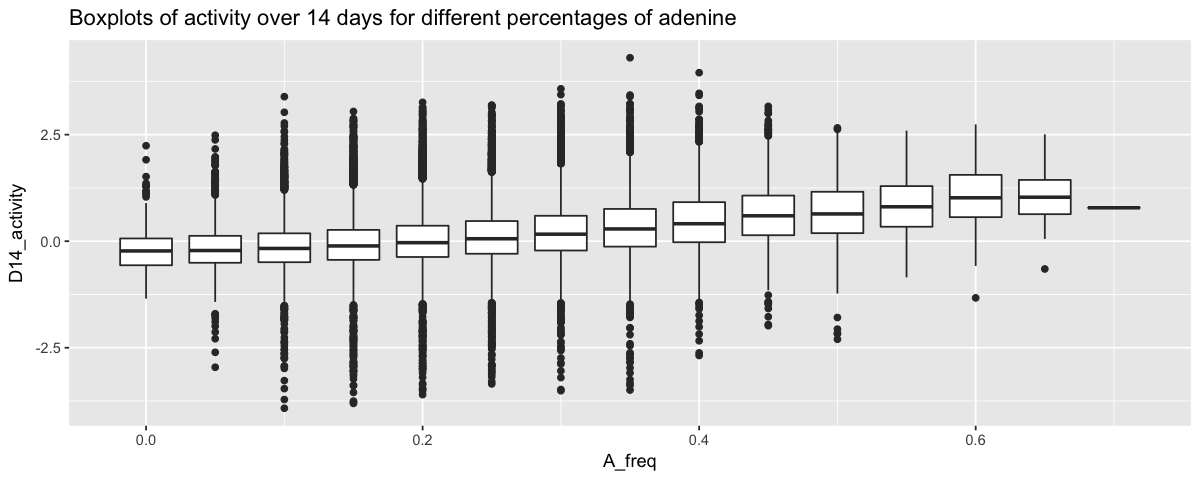

In [605]:
ggplot(crispr_data) + geom_boxplot(mapping=aes(x=A_freq,y=D14_activity,group=A_freq)) + ggtitle("Boxplots of activity over 14 days for different percentages of adenine")

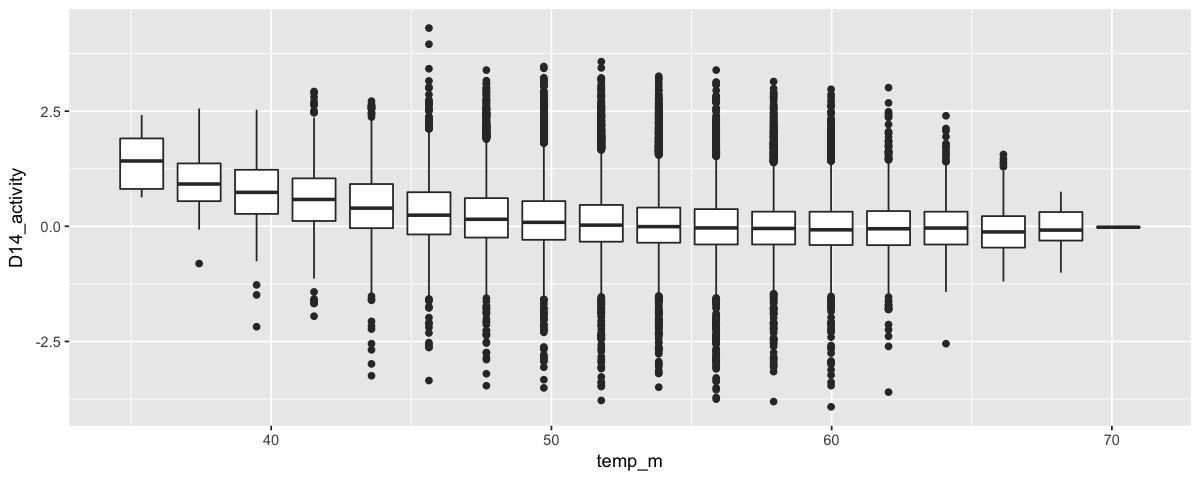

In [606]:
ggplot(crispr_data) + geom_boxplot(mapping=aes(x=temp_m,y=D14_activity,group=temp_m))

In [607]:
#include the percentage of guanines and cytosines in the sequence
crispr_data = mutate(crispr_data,GC_content = G_freq+C_freq)

## 3. Location in the human reference genome

To unconver a greater understanding into the possible "why's" of which sequences are most effective we can determine the location of the gene targeted in the human genome. To do this we export the guide sequences and use the C++ program Bowtie to reference against the human genome. We can then import the results:

In [609]:
#import data from bowtie output and add to dataset
chrom = suppressMessages(read_delim("data/chrom.txt","\t", escape_double = FALSE, col_names = FALSE, comment = "#", trim_ws = TRUE))
chrom = dplyr::select(chrom, chr=X3)
crispr_data = cbind(crispr_data,chrom)
crispr_data = mutate(crispr_data,chrom=str_replace(chr,"chr",""))
crispr_data = dplyr::select(crispr_data,-chr)

In [610]:
crispr_data %>% select(spacer_seq,chrom) %>% head()

spacer_seq,chrom
ACCTGTAGTTGCCGGCGTGC,19
GTCGCTGAGCTCCGATTCGA,19
AAGTTGCTTGATTGCATTCT,10
ACTTCCCCGAGACCTTTTTG,10
AGTGCCGCTCAATCCATCCC,10
CGCGCACTGGTCCAGCGCAC,10


<br />
By referencing the human genome we can now investigate whether any particular chromosome holds an abundance of genes which are essential to stopping growth of the cell. Unfortunately, no particular chromosome appears to have a greater distribution of activity than the others:

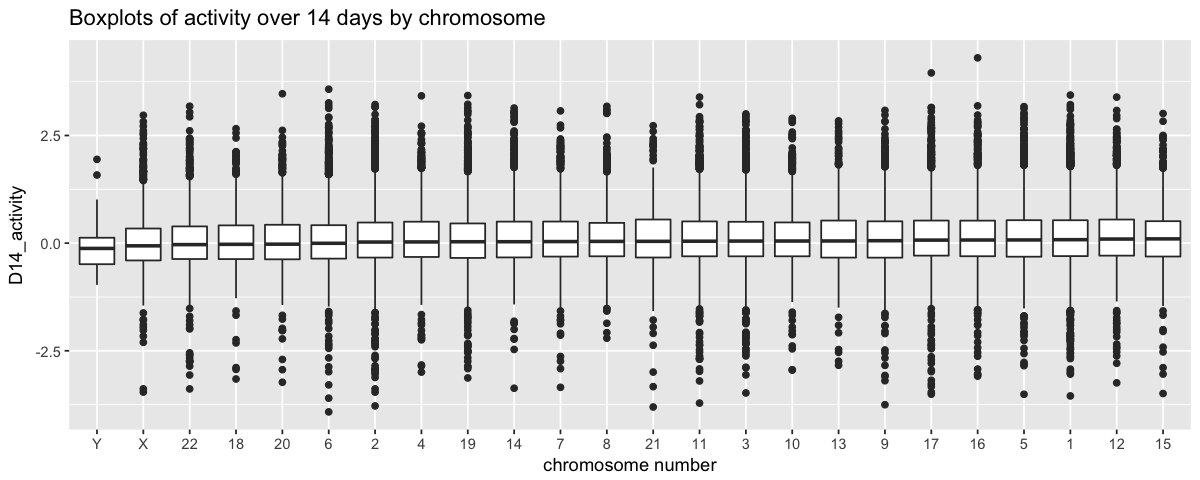

In [615]:
crispr_data %>% group_by(chrom) %>% ggplot() + geom_boxplot(mapping=aes(x=reorder(chrom,D14_activity,FUN=median),y=D14_activity,group=chrom)) + xlab("chromosome number") + ggtitle("Boxplots of activity over 14 days by chromosome")

## 4. Gene Ontology

Once we have determined which guides have the greatest activity we would like to be able to understand more about the gene which the guide targets, and why targeting this gene results in the desired effect. In order to do this we can annotate the genes in the dataset with their biological process using the GO.db package from Bioconductor.  

In [616]:
#read the gene annotations (saved for demonstration)
annotations = suppressMessages(read_csv("data/gene_BP.txt", col_names = FALSE))
annotations = as_tibble(annotations)
annotations = dplyr::select(annotations,gene_BP=X1)
crispr_data = cbind(annotations,crispr_data)

In [617]:
crispr_data %>% select(gene_BP,gene_name,spacer_seq) %>% head()

gene_BP,gene_name,spacer_seq
platelet degranulation,A1BG,ACCTGTAGTTGCCGGCGTGC
platelet degranulation,A1BG,GTCGCTGAGCTCCGATTCGA
mRNA processing,A1CF,AAGTTGCTTGATTGCATTCT
mRNA processing,A1CF,ACTTCCCCGAGACCTTTTTG
mRNA processing,A1CF,AGTGCCGCTCAATCCATCCC
mRNA processing,A1CF,CGCGCACTGGTCCAGCGCAC


<br />
Unfortunately the biological process of many genes are still unknown, coded as NA, or simply annotated as "biological_process":



In [618]:
crispr_data %>% group_by(gene_BP) %>% count() %>% mutate(percentage = n/nrow(crispr_data)) %>% arrange(desc(n)) %>% head(10)

gene_BP,n,percentage
NA,9579,0.149494
"transcription, DNA-templated",2989,0.046648
negative regulation of transcription from RNA polymerase II promoter,2602,0.040608
G-protein coupled receptor signaling pathway,1242,0.019383
biological_process,997,0.015560
proteolysis,936,0.014608
signal transduction,907,0.014155
MAPK cascade,825,0.012875
transport,667,0.010410
protein polyubiquitination,571,0.008911


<br />Regardless of this, over representation of a particular process in the most active guide clusters may help guide further research.

## 5. Clustering

Now we have added sufficient additional information to our dataset we shall use t-SNE to reduce our data into a 2-dimensional representation, and then the DBSCAN clustering algorithm to assign clusters to the data.

Once the data is clustered we will investigate which of the clusters have the highest activities and what characteristics of the cluster contribute to its high activity.

For the purposes of presentation we import the data and only display the results of the t-SNE calculation and clustering:

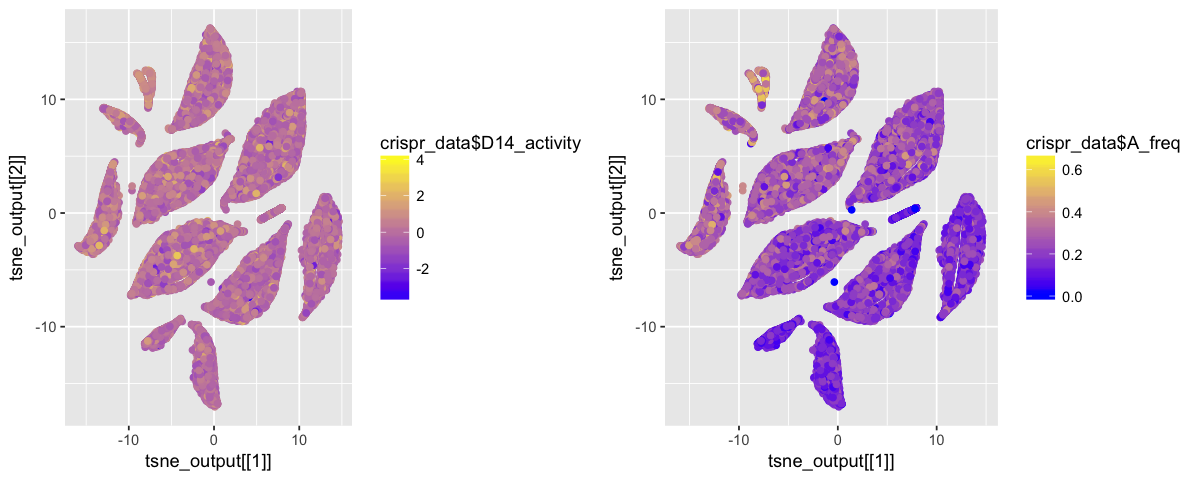

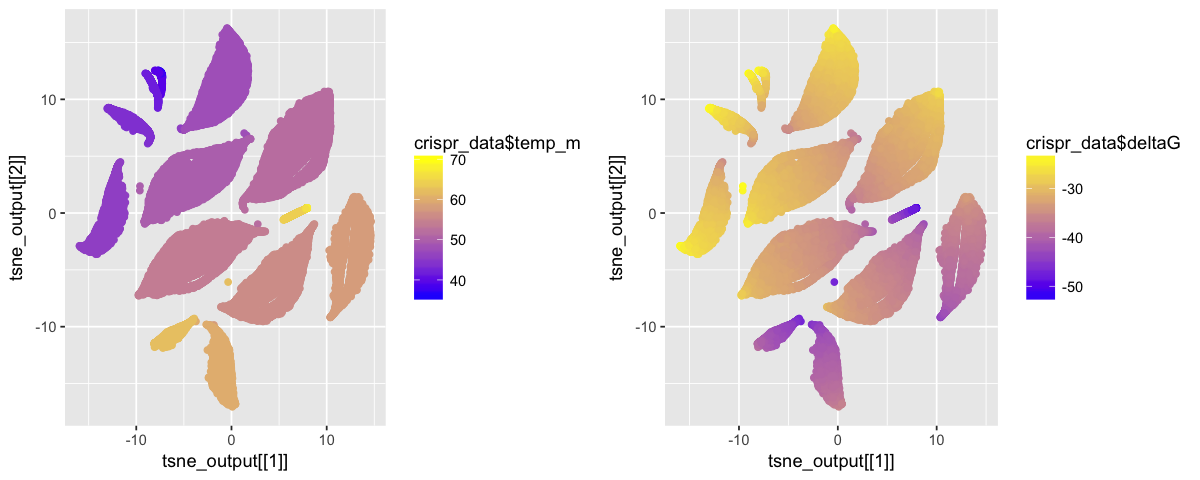

In [620]:
#read the t-SNE output
tsne_output = suppressWarnings(suppressMessages(read_csv("data/tsne_output.txt", col_names = TRUE)))
tsne_output = tsne_output[,2:3]

#plot the t-SNE output to see how the data has been clustered
p1 = ggplot(tsne_output) + geom_point(mapping=aes(x=tsne_output[[1]],y=tsne_output[[2]],color=crispr_data$D14_activity)) + scale_colour_gradient(low = "blue", high = "yellow")
p2 = ggplot(tsne_output) + geom_point(mapping=aes(x=tsne_output[[1]],y=tsne_output[[2]],color=crispr_data$A_freq)) + scale_colour_gradient(low = "blue", high = "yellow")
p3 = ggplot(tsne_output) + geom_point(mapping=aes(x=tsne_output[[1]],y=tsne_output[[2]],color=crispr_data$temp_m)) + scale_colour_gradient(low = "blue", high = "yellow")
p4 = ggplot(tsne_output) + geom_point(mapping=aes(x=tsne_output[[1]],y=tsne_output[[2]],color=crispr_data$deltaG)) + scale_colour_gradient(low = "blue", high = "yellow")
grid.arrange(p1,p2,ncol=2)
grid.arrange(p3,p4,ncol=2)

<br />
From looking at the plots above alone we can already deduce that the clusters with the seemingly highest activity over 14 days have a high frequency of adenines, low melting temperature and a Gibb's free energy closer to zero.

We can now use DBSCAN to cluster the dimensionality reduction output and add the cluster assignments to our data set for further analysis:


<img src="images/DBSCAN_clusters.png" alt="Drawing" style="width: 800px;"/>

In [621]:
#load cluster assignments and add them to our dataset
clusters = suppressMessages(suppressWarnings(read_csv("data/DBSCAN_clusters.txt", col_names = TRUE)))
clusters = clusters[,2]
clusters = select(clusters,cluster=x)
crispr_data = cbind(crispr_data,clusters)
crispr_data %>% select(spacer_seq,cluster) %>% head()
crispr_data = crispr_data %>% group_by(cluster)

spacer_seq,cluster
ACCTGTAGTTGCCGGCGTGC,1
GTCGCTGAGCTCCGATTCGA,2
AAGTTGCTTGATTGCATTCT,3
ACTTCCCCGAGACCTTTTTG,4
AGTGCCGCTCAATCCATCCC,2
CGCGCACTGGTCCAGCGCAC,5


cluster,avg_D14_activity,avg_D14_activity_PLX,cluster_size
10,0.665093,1.671,1143
9,0.462263,1.479,2140
3,0.316197,1.408,4341
6,0.224176,1.308,6972
7,0.171248,1.270,8876
4,0.085629,1.187,19184
2,0.015008,1.148,8249
1,-0.004527,1.110,6201
5,-0.017578,1.073,6000
8,-0.024811,1.061,970


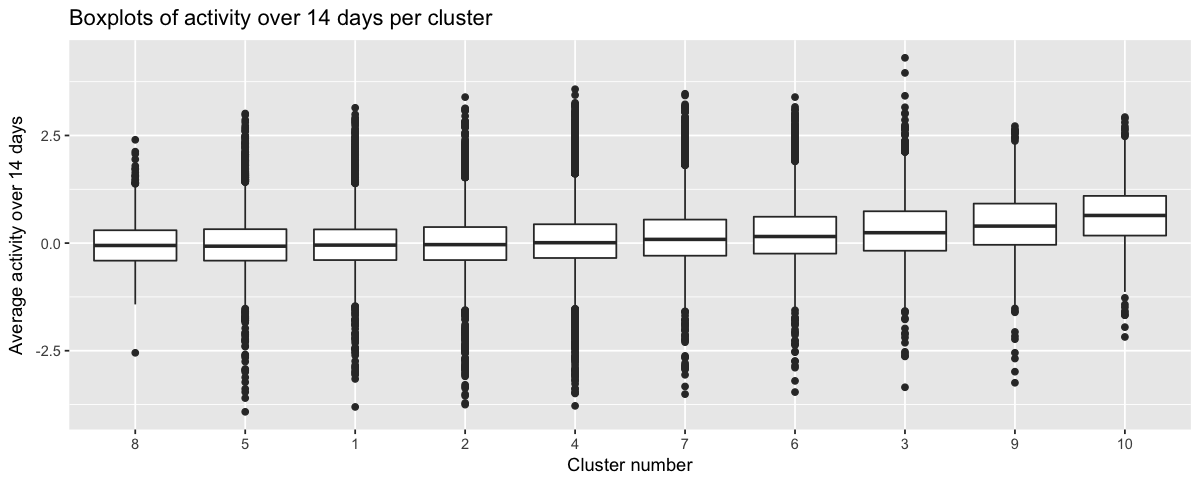

In [622]:
#tabulate and plot the clusters by their activity over 14 days
crispr_data %>% summarize(avg_D14_activity=mean(D14_activity),avg_D14_activity_PLX=mean(D14_activity_PLX),cluster_size=n()) %>% arrange(desc(avg_D14_activity))
ggplot(crispr_data) + geom_boxplot(mapping=aes(x=reorder(cluster,D14_activity),y=D14_activity)) + xlab("Cluster number") + ylab("Average activity over 14 days") + ggtitle("Boxplots of activity over 14 days per cluster")

<br/>
Above we can see that cluster number ten, the small blue cluster in the upper left corner of the cluster plot, is the cluster with the highest average activity over 14 days both with and without the drug condition. Given the varying cluster sizes, lets determine if the difference is statistically significant:

In [623]:
#seperate cluster 10 from the rest and determine if the average activity over 14 days is different
cluster10 = crispr_data %>% filter(cluster==10)
other_clusters = crispr_data %>% filter(cluster!=10)
#conduct t-test
print("Without PLX:")
t.test(cluster10$D14_activity,other_clusters$D14_activity,alternative="greater")
print ("With PLX:")
t.test(cluster10$D14_activity_PLX,other_clusters$D14_activity_PLX,alternative="greater")

[1] "Without PLX:"



	Welch Two Sample t-test

data:  cluster10$D14_activity and other_clusters$D14_activity
t = 26, df = 1200, p-value <0.0000000000000002
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.5179    Inf
sample estimates:
mean of x mean of y 
   0.6651    0.1121 


[1] "With PLX:"



	Welch Two Sample t-test

data:  cluster10$D14_activity_PLX and other_clusters$D14_activity_PLX
t = 14, df = 1200, p-value <0.0000000000000002
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.4058    Inf
sample estimates:
mean of x mean of y 
    1.671     1.212 


<br/> 
Indeed we find that cluster 10 has a larger average activity over 14 days compared to other clusters. Lets check if the average activity over 14 days between the top two clusters, clusters 10 and 9, is statistically different:

In [624]:
cluster9 = crispr_data %>% filter(cluster==9)
print("Without PLX:")
t.test(cluster10$D14_activity,cluster9$D14_activity,alternative="greater")
print("With PLX:")
t.test(cluster10$D14_activity_PLX,cluster9$D14_activity_PLX,alternative="greater")

[1] "Without PLX:"



	Welch Two Sample t-test

data:  cluster10$D14_activity and cluster9$D14_activity
t = 7.8, df = 2300, p-value = 0.000000000000006
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.1599    Inf
sample estimates:
mean of x mean of y 
   0.6651    0.4623 


[1] "With PLX:"



	Welch Two Sample t-test

data:  cluster10$D14_activity_PLX and cluster9$D14_activity_PLX
t = 4.8, df = 2400, p-value = 0.0000008
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.1262    Inf
sample estimates:
mean of x mean of y 
    1.671     1.479 


<br/>
We see from above with 95% confidence cluster 10 has an average activity of 0.1599 or more above cluster 9 without PLX, and 0.1262 or above with PLX. 

## 6. Comparative Analysis 


In the following section we will conduct a comparative analysis between the clusters to determine what features of the most effective guides correlate with activity.

In the previous section we determined that cluster 10 was in fact the most active cluster in the dataset, with an average activity of ~0.67 without PLX and ~1.67 with. In the following we will compare cluster 10, the most active cluster, against the other clusters in the data.

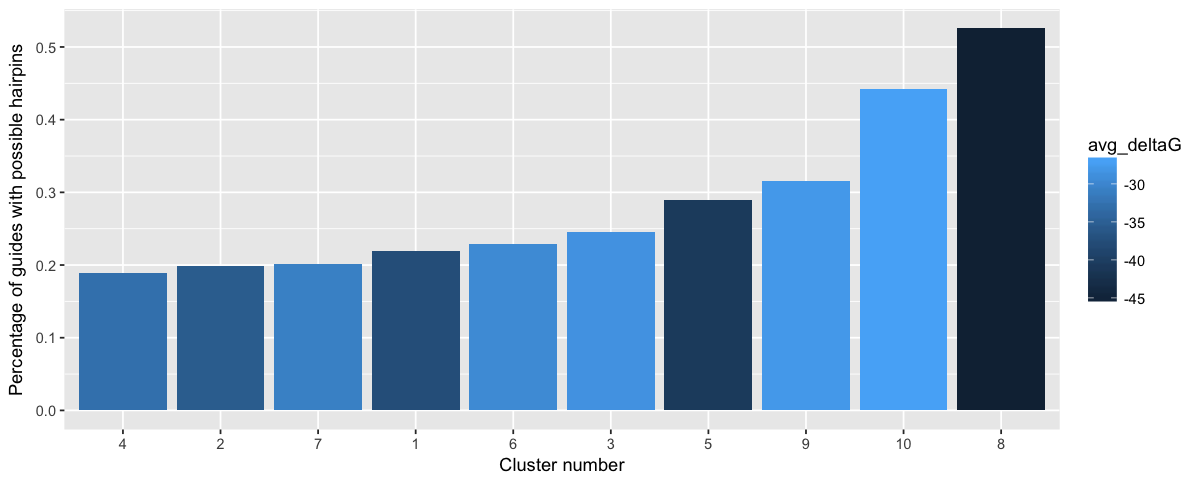

In [625]:
#plot of percentage of guides with hairpins possible per cluster
crispr_data %>% group_by(cluster) %>% summarize(hairpin_percentage=mean(hairpins),avg_deltaG = mean(deltaG)) %>% ggplot() + geom_col(mapping=aes(x=reorder(cluster,hairpin_percentage),y=hairpin_percentage,fill=avg_deltaG)) + xlab("Cluster number") + ylab("Percentage of guides with possible hairpins")

Interestingly cluster 10, the most active, is second to cluster 8, the lease active, for the percentage of guides in the cluster which have sequences which can form a secondary structure. However, when we plot this result and colour by the average Gibb's free energy we see cluster 8 has the largest negative value and cluster 10 the smallest negative value.

This observation therefore indicates that although secondary structures are possible, the Gibb's free energy in the most active guides is not large enough to create stable hairpin structures. On the contrary, in cluster 8 the large negative Gibb's free energy value allows the guide to fold into a stable secondary structure to the detriment of its activity.

Next we will compare the position specific nucleotide composition:

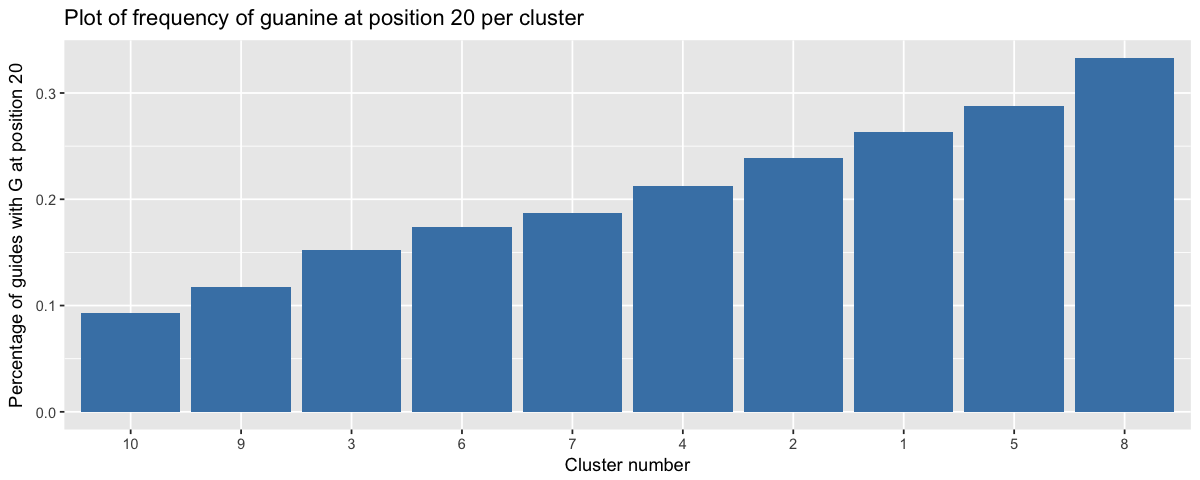

In [626]:
crispr_data %>% group_by(cluster) %>% summarize(G_end_percentage=mean(G_end)) %>% ggplot() + geom_col(mapping=aes(x=reorder(cluster,G_end_percentage),y=G_end_percentage),fill='steelblue') + xlab("Cluster number") + ylab("Percentage of guides with G at position 20") + ggtitle("Plot of frequency of guanine at position 20 per cluster")

Contrary to the findings of Doench et al. [4] we find that the most effective guides do not contain a guanine adjacent to the PAM. In fact the relationship is completely reversed, in that the most effective cluster has the least percentage of guides with this feature, and the least effective has the most.

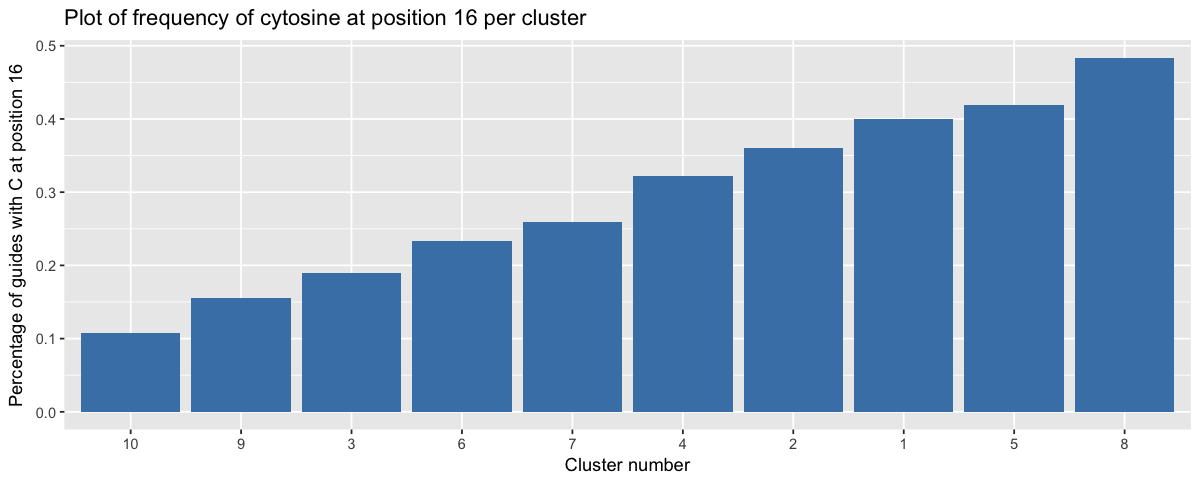

In [627]:
crispr_data %>% group_by(cluster) %>% summarize(C_16_percentage = mean(C_16)) %>% ggplot() + geom_col(mapping=aes(x=reorder(cluster,C_16_percentage),y=C_16_percentage),fill='steelblue') + xlab("Cluster number") + ylab("Percentage of guides with C at position 16") + ggtitle("Plot of frequency of cytosine at position 16 per cluster")

Likewise, we saw a direct contrast to Doench's observations that a cytosine at position 16 in the guide sequence is more frequently observed in the most active guides.

On the other hand we reproduced the findings of Wong et al. [2] exactly - the guides with the largest number of repetitive bases, in particular GGGG, were associated with low activity clusters.

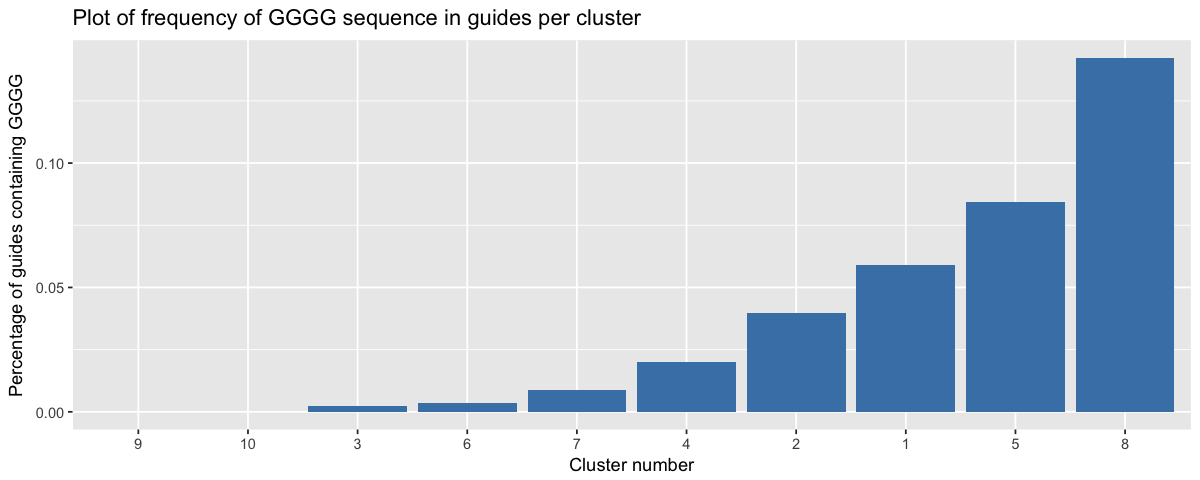

In [628]:
crispr_data %>% group_by(cluster) %>% summarize(GGGG_percentage = mean(GGGG)) %>% ggplot() + geom_col(mapping=aes(x=reorder(cluster,GGGG_percentage),y=GGGG_percentage),fill='steelblue') + xlab("Cluster number") + ylab("Percentage of guides containing GGGG") + ggtitle("Plot of frequency of GGGG sequence in guides per cluster")

<br/>
We saw further confirmations of the findings of the study by Wong et al. by observing that the clusters with higher associated average activity over 14 days had a normal distribution with a higher average frequency of adenines than those associated with low activity.

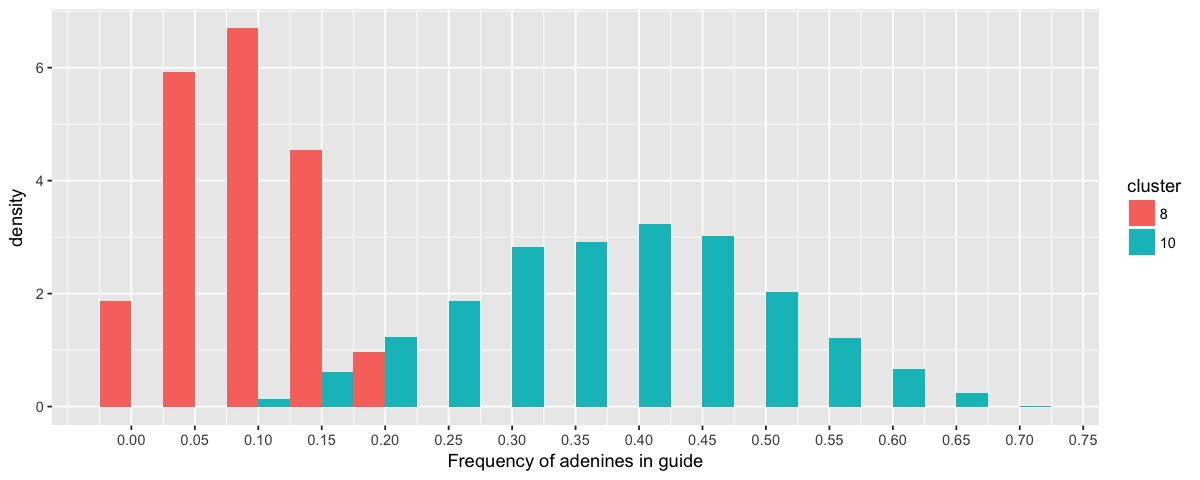

In [630]:
A_dist = crispr_data %>% filter(cluster==10 ||cluster==8) %>% select(A_freq,cluster)
A_dist$cluster = as.factor(A_dist$cluster)
ggplot(A_dist) + geom_histogram(mapping=aes(x=A_freq,y=..density..,fill=cluster),position='dodge',binwidth=0.05) + scale_x_continuous(breaks=seq(0,1,0.05)) + xlab("Frequency of adenines in guide")

<br />
Interestingly, we see that the clusters with higher average frequency of adenines also have a greater standard deviation. This suggests to us that the relationsip with frequency of adenines and average activity is not linear, and that too little or too much adenine content is in fact detrimental to guide activity. 

In [631]:
crispr_data %>% group_by(cluster) %>% summarize(sd_A_freq = sd(A_freq)) %>% arrange(desc(sd_A_freq))

cluster,sd_A_freq
10,0.11568
9,0.10257
3,0.09575
6,0.09157
7,0.08842
4,0.08079
2,0.07209
1,0.06751
5,0.06108
8,0.05166


Analysing the frequency of adenine in the guide against the activity over 14 days for cluster 10 (the most active), we see that ~60% adenine content appears to be optimal.

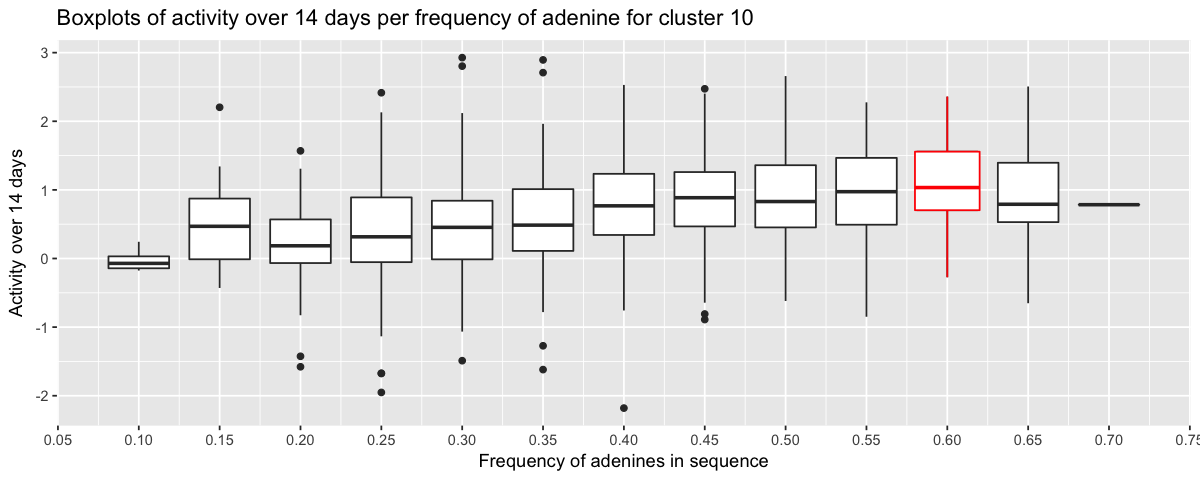

In [632]:
plot = crispr_data %>% filter(cluster==10)
optim = plot %>% filter(A_freq==0.6)
ggplot(plot) + geom_boxplot(mapping=aes(x=A_freq,y=D14_activity,group=A_freq)) + scale_x_continuous(breaks=seq(0,1,0.05)) + xlab("Frequency of adenines in sequence") + ylab("Activity over 14 days") + ggtitle("Boxplots of activity over 14 days per frequency of adenine for cluster 10") + geom_boxplot(data=optim,mapping=aes(x=A_freq,y=D14_activity),color='red',width=0.04)

<br/>
Furthermore, we see cluster 10 (most active) and cluster 8 (least active) on opposite sides of the melting temperature scale, owing to their vastly different average guanine and cytosine content. 

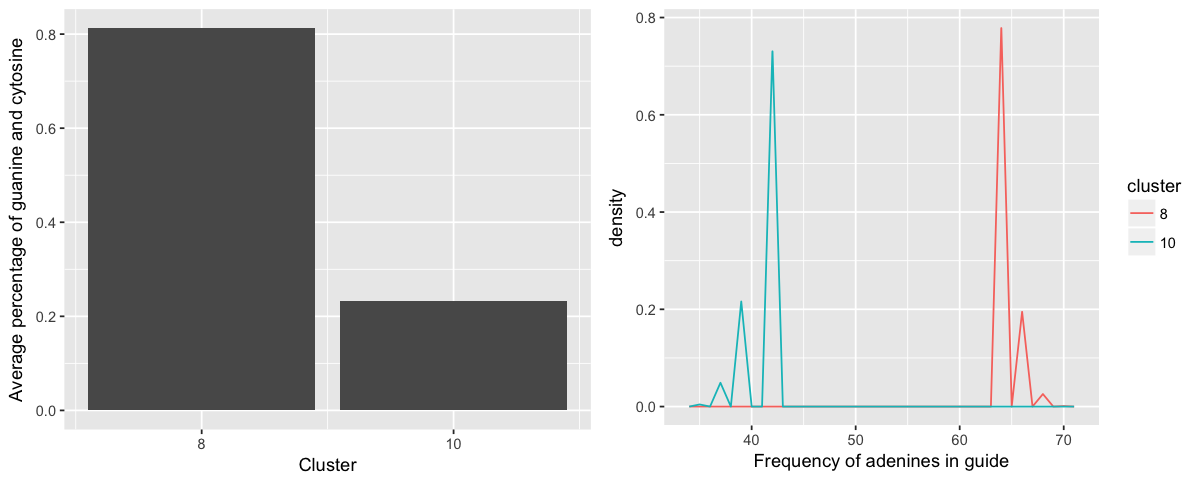

In [633]:
temp_dist = crispr_data %>% filter(cluster==10 || cluster ==8)
temp_dist$cluster = as.factor(temp_dist$cluster)
p1 = temp_dist %>% summarize(avg_GC_content=mean(GC_content)) %>% ggplot() + geom_col(mapping=aes(x=cluster,y=avg_GC_content)) + scale_x_continuous(breaks=c(8,10)) + xlab("Cluster") + ylab("Average percentage of guanine and cytosine")
p2 = ggplot(temp_dist) + geom_freqpoly(mapping=aes(x=temp_m,y=..density..,color=cluster),binwidth=1) + xlab("Frequency of adenines in guide")
grid.arrange(p1,p2,ncol=2)

<br/>
Next we move on to compare the location of the target in the human reference genome across clusters. In the entire data set we find a fairly even split across chromosomes, with genes located in chromosomes number 1 being the most numerous:

In [634]:
crispr_data %>% group_by(chrom) %>% count() %>% arrange(desc(n)) %>% mutate(percentage=n/nrow(crispr_data)) %>% head(10)

chrom,n,percentage
1,7889,0.12312
2,4799,0.07490
19,4308,0.06723
3,4182,0.06527
11,3833,0.05982
17,3500,0.05462
12,3301,0.05152
6,3152,0.04919
4,2795,0.04362
5,2775,0.04331


We notice a statistically significant overrepresentation of target genes which reside in chromosome 4 in the most active guide clusters:

In [635]:
crispr_data %>% filter(cluster==10) %>% group_by(chrom) %>% count() %>% arrange(desc(n)) %>% mutate(percentage=n/nrow(filter(crispr_data,cluster==10))) %>% head(5)

chrom,n,percentage
1,135,0.11811
2,124,0.10849
3,100,0.08749
4,98,0.08574
5,78,0.06824


In [636]:
prop.test(c(98,2795),c(nrow(filter(crispr_data,cluster==10)),nrow(crispr_data)))


	2-sample test for equality of proportions with continuity correction

data:  c(98, 2795) out of c(nrow(filter(crispr_data, cluster == 10)), nrow(crispr_data))
X-squared = 46, df = 1, p-value = 0.00000000001
alternative hypothesis: two.sided
95 percent confidence interval:
 0.02537 0.05887
sample estimates:
 prop 1  prop 2 
0.08574 0.04362 


<br/>
It is possible however that this is a spurious observation and the result of selection bias in the experiment.

We can conduct a similar comparison for the gene ontology to determine if particular biological processes are overrepresented in high activity clusters. In the general population we find NA's and non descriptive annotations such as "biological_function" to make up ~16.5% of the data. Amongst the most numerous biological functions are annotations pertaining to transcription:

In [638]:
crispr_data %>% group_by(gene_BP) %>% count() %>% arrange(desc(n)) %>% mutate(proportion=n/nrow(crispr_data)) %>% head(20)

gene_BP,n,proportion
NA,9579,0.149494
"transcription, DNA-templated",2989,0.046648
negative regulation of transcription from RNA polymerase II promoter,2602,0.040608
G-protein coupled receptor signaling pathway,1242,0.019383
biological_process,997,0.015560
proteolysis,936,0.014608
signal transduction,907,0.014155
MAPK cascade,825,0.012875
transport,667,0.010410
protein polyubiquitination,571,0.008911


In the high activity clusters we only notice a small statistically significant overrepresentation of "G2/M transition of mitotic cell cycle":

In [639]:
crispr_data %>% filter(cluster==10) %>% group_by(gene_BP) %>% count() %>% arrange(desc(n)) %>% mutate(proportion=n/nrow(filter(crispr_data,cluster==10))) %>% head(10)

gene_BP,n,proportion
NA,179,0.15661
"transcription, DNA-templated",44,0.03850
negative regulation of transcription from RNA polymerase II promoter,33,0.02887
biological_process,20,0.01750
proteolysis,19,0.01662
G2/M transition of mitotic cell cycle,18,0.01575
"mRNA splicing, via spliceosome",15,0.01312
MAPK cascade,13,0.01137
"regulation of transcription, DNA-templated",13,0.01137
apoptotic process,12,0.01050


In [640]:
n_entire = nrow(crispr_data)
n_cluster = nrow(crispr_data %>% filter(cluster==10))
print("Proportions test for G2/M transition of mitotic cell cycle")
prop.test(c(18,384),c(n_cluster,n_entire))

[1] "Proportions test for G2/M transition of mitotic cell cycle"



	2-sample test for equality of proportions with continuity correction

data:  c(18, 384) out of c(n_cluster, n_entire)
X-squared = 16, df = 1, p-value = 0.00007
alternative hypothesis: two.sided
95 percent confidence interval:
 0.002068 0.017443
sample estimates:
  prop 1   prop 2 
0.015748 0.005993 


<br/>
This observation could present an opportunity for further research as we can see that guides which target the genes annotated as having the biological process of "G2/M transition of mitotic cell cycle" have a statistically significant greater activity than others:

In [641]:
#calculate the average activies for G2/M transition of mitotic cell cycle versus other proccesses
g2_process = crispr_data %>% ungroup() %>% filter(gene_BP=="G2/M transition of mitotic cell cycle") %>% summarize(avg_activity=mean(D14_activity),avg_activity_PLX=mean(D14_activity_PLX)) %>% mutate(process="G2/M transition of mitotic cell cycle")
other_process = crispr_data %>% ungroup() %>% filter(gene_BP!="G2/M transition of mitotic cell cycle") %>% summarize(avg_activity=mean(D14_activity),avg_activity_PLX=mean(D14_activity_PLX)) %>% mutate(process="other")
rbind(g2_process,other_process)
g2_process = crispr_data %>% ungroup() %>% filter(gene_BP=="G2/M transition of mitotic cell cycle")
other_process = crispr_data %>% ungroup() %>% filter(gene_BP!="G2/M transition of mitotic cell cycle")
t.test(g2_process$D14_activity,other_process$D14_activity,alternative="greater")


avg_activity,avg_activity_PLX,process
0.4186,1.464,G2/M transition of mitotic cell cycle
0.1264,1.219,other



	Welch Two Sample t-test

data:  g2_process$D14_activity and other_process$D14_activity
t = 7, df = 390, p-value = 0.000000000006
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.2232    Inf
sample estimates:
mean of x mean of y 
   0.4186    0.1264 


<br/> 
The G2 checkpoint is a process in the cell cycle in which the cell checks for any damage which may have occured during replication before it can transition into the mitosis phase. It is possible that by targeting and disrupting the function of genes which contribute to the G2 checkpoint we prevent cells from entering mitosis and replicating. If this is the case, it would clearly be of great interest for preventing the replication of cancerous cells. Indeed abrogating the G2 checkpoint has been the focus of cancer specific cell cycle disruption in the past, as seen through research by Kawabe [5].

Investgating the relationship between activity and biological process further, and momentarily disregarding the clusters, we find large average activity for various biological processes. Unfortunately the sample sizes are too small to be statistically significant for the top results:

In [642]:
crispr_data %>% group_by(gene_BP) %>% summarize(avg_activity=mean(D14_activity),avg_activityPLX=mean(D14_activity_PLX),count=n()) %>% arrange(desc(avg_activity)) %>% head()

ribosome_process = crispr_data %>% ungroup() %>% filter(gene_BP=="ribosome assembly")
other_process = crispr_data %>% ungroup() %>% filter(gene_BP!="ribosome assembly")
t.test(ribosome_process$D14_activity,other_process$D14_activity)

gene_BP,avg_activity,avg_activityPLX,count
ribosome assembly,3.014,3.552,3
maturation of LSU-rRNA,2.202,2.991,3
lysosomal lumen acidification,2.076,2.274,3
cysteinyl-tRNA aminoacylation,2.026,2.168,3
regulation of nucleic acid-templated transcription,1.987,3.109,3
negative regulation of protein ADP-ribosylation,1.839,2.576,4



	Welch Two Sample t-test

data:  ribosome_process$D14_activity and other_process$D14_activity
t = 4.2, df = 2, p-value = 0.05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.09665  5.86876
sample estimates:
mean of x mean of y 
   3.0143    0.1283 


Filtering for processes with sufficient counts to be statistically significant we see genes annotated with the "N-terminal peptidyl-methionine acetylation" process to have a greater average activity:


In [643]:
crispr_data %>% group_by(gene_BP) %>% summarize(avg_activity=mean(D14_activity),avg_activityPLX=mean(D14_activity_PLX),count=n()) %>% filter(count>10) %>% arrange(desc(avg_activity)) %>% head(5)

ribosome_process = crispr_data %>% ungroup() %>% filter(gene_BP=="N-terminal peptidyl-methionine acetylation")
other_process = crispr_data %>% ungroup() %>% filter(gene_BP!="N-terminal peptidyl-methionine acetylation")
t.test(ribosome_process$D14_activity,other_process$D14_activity)

gene_BP,avg_activity,avg_activityPLX,count
N-terminal peptidyl-methionine acetylation,1.442,2.026,11
ribosomal subunit export from nucleus,1.123,2.258,11
transcription initiation from RNA polymerase I promoter,1.087,2.010,20
"exonucleolytic trimming to generate mature 3'-end of 5.8S rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)",1.069,1.700,14
cardiolipin biosynthetic process,1.043,2.014,11



	Welch Two Sample t-test

data:  ribosome_process$D14_activity and other_process$D14_activity
t = 5.8, df = 10, p-value = 0.0002
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.8092 1.8193
sample estimates:
mean of x mean of y 
   1.4424    0.1282 


In [644]:
crispr_data %>% filter(gene_BP=="N-terminal peptidyl-methionine acetylation") %>% arrange(D14_activity) %>%head()

gene_BP,gene_name,spacer_id,spacer_seq,plasmid,avg_D7,avg_D14,avg_D7_PLX,avg_D14_PLX,D7_activity,⋯,A_freq,A_count,T_freq,C_freq,G_freq,GC_content,GGGG,temp_m,chrom,cluster
N-terminal peptidyl-methionine acetylation,NAA25,s_35903,AGAGTGATACTCCTCACTAT,17.692,13.217,12.383,11.471,7.288,0.42072,⋯,0.30,6,0.30,0.25,0.15,0.40,0,47.68,12,6
N-terminal peptidyl-methionine acetylation,NAA20,s_35902,GCGAGGTATTGTAGGTAGAA,14.330,14.318,9.517,13.030,2.701,0.00116,⋯,0.30,6,0.25,0.05,0.40,0.45,0,49.73,20,7
N-terminal peptidyl-methionine acetylation,NAA25,s_35906,GACACTCACCGTAAATGGGC,7.365,5.736,4.752,12.354,18.559,0.36066,⋯,0.30,6,0.15,0.30,0.25,0.55,0,53.83,12,4
N-terminal peptidyl-methionine acetylation,NAA25,s_35904,CGCTTGTCATCATGGCGACG,4.963,3.088,2.581,2.728,1.428,0.68470,⋯,0.15,3,0.25,0.30,0.30,0.60,0,55.88,12,2
N-terminal peptidyl-methionine acetylation,NAA20,s_35900,AAGGATACAGTTTCTGTAAG,19.133,13.118,9.063,14.223,4.930,0.54453,⋯,0.35,7,0.30,0.10,0.25,0.35,0,45.63,20,3
N-terminal peptidyl-methionine acetylation,NAA30,s_35907,ATCACAGTCTCCCTCAACCA,15.891,5.847,5.323,6.403,3.325,1.44237,⋯,0.30,6,0.20,0.45,0.05,0.50,0,51.78,14,4


<br/>

We see that the genes for this biological process are the NAA20, NAA25 and NAA30 genes, all of which are associated with NatB-mediated protein N-α-terminal acetylation. Previous research by Neri et al. [6] has shown that the NatB subunits are significantly upregulated in over 59% of hepatocellular carcinoma tumors. Disrupting the expression of these genes may therefore prevent survival, cell growth and tumor progression and is an area for further research.


## 7. Conclusion

To conclude, we found that guide activity is on average greater when combined with the use of Vemurafenib (PLX). In contrast, for approximately 9% of cases the drug appears to hinder performance of the guide. We hypothesised that this could be due to fact PLX can promote tumor growth when used with cancers which are not a melanoma with the V600E BRAF mutation. 

We went on to cluster the data set, finding approximately ten clusters with varying activies and antributes. Of all clusters, cluster number 10 was found to have the highest activity with an average of ~0.67 without PLX and 1.67 with. Interestingly, many hairpin formations in the guide sequences of the highest activity cluster were possible, but low Gibb's free energy likely prevented stable structures from forming. In addition, we found the highest activity clusters to have the smallest content of cytosine and guanine, and this reflected in their low melting temperature.

Contrary to prior findings by Doench et al. [4] we found that a guanine at the position adjacent to the PAM was in fact least frequent in the high activity clusters and most frequent in the low activity ones. Likewise we found the same result for a cytosine at position 16.

On the other hand, we observed findings in line with previous research by Wong et al. [2]. High activity guides were characteristed by a disfavour for repetitive bases, in particular four contiguous guanines, and a high relative adenine content. In our data we found the optimal percentage of adenine to be approximately 60%. 

By referencing the genes targeted against the human genome we were able to analyse if any particular chromosome held an abundance of genes which were essential for survival cell survival. In doing so we found a small but statistically significant overrepresentation of chromosome 4 in the highest activity cluster.

Futhermore, we used annotations of the gene's biological process to identify an overrepresentation of genes relevent to the G2 checkpoint in the mitosis cell cycle. Previous research by Kawabe [5] indicates that abrogating this checkpoint could disrupt cancer cell reproduction.

Finally, we analysed all data with respect to the targeted gene's biological function and found that genes associated with NatB and its subunits had high guide activities. Previous research by Neri et al. [6] had suggested preventing this process could prevent cell survival and growth in certain cancers.

## References

[1] Hatzivassiliou G, Song K, Yen I, Brandhuber BJ, Anderson DJ, Alvarado R, Ludlam MJ, Stokoe D, Gloor SL, Vigers G, Morales T, Aliagas I, Liu B, Sideris S, Hoeflich KP, Jaiswal BS, Seshagiri S, Koeppen H, Belvin M, Friedman LS, Malek S (February 2010). "RAF inhibitors prime wild-type RAF to activate the MAPK pathway and enhance growth". Nature. 464 (7287): 431–5.

[2] Wong N, Liu W, Wang X. WU-CRISPR: characteristics of functional guide RNAs for the CRISPR/Cas9 system. Genome      Biology. DOI 10.1186/s13059-015-0784-0.

[3] Jensen K, Fløe L, Petersen T, Huang J, Xu F, Bolund L, Luo Y, Lin L. Chromatin accessibility and guide sequence secondary structure affect CRISPR‐Cas9 gene editing efficiency. FEBS Letters 591 (2017) 1892–1901.

[4] Doench J, Hartenian E, Graham D, Tothova Z, Hegde M, Smith I, Sullender M, Ebert B, Xavier R & Root D. Rational design of highly active sgRNAs for CRISPR-Cas9–mediated gene inactivation. Nature Biotechnology volume 32, pages 1262–1267 (2014).

[5] Kawabe T. G2 checkpoint abrogation as a cancer specific, cell cycle disruption. Ann. Cancer Res. Therap. Vol. 13, Nos. 1 & 2, pp. 17-22, 2005.

[6] Neri L, Lasa M, Elosegui-Artola A, D’Avola D, Carte B, Gazquez C, Aldabe R. (2017). NatB-mediated protein N-α-terminal acetylation is a potential therapeutic target in hepatocellular carcinoma. Oncotarget, 8(25), 40967–40981. http://doi.org/10.18632/oncotarget.17332

## Resources

Oligoprop - MATLAB Bioinformatics toolbox library https://www.mathworks.com/help/bioinfo/ref/oligoprop.html

Bowtie - An ultrafast memory-efficient short read aligner. http://bowtie-bio.sourceforge.net/index.shtml

Bioconductor - Open source software for bioinformatics https://www.bioconductor.org

GO.db - A set of annotation maps describing the entire Gene Ontology. R package version 3.5.0. 

